# Computing the Partion Function

The schrodinger_X() modules provide eigenstates that can be used directly in an ensemble of your choice (each with there own unique free energy). In this document, we will cover the availible ensemble implimented in QWavE and how to do some simple boltzmann statistics.

## Canonical Ensemble

The canonical ensemble represents the possible states of a mechanicla system in thermal equilibrium with a heat bath at a fixed temperature. The principle thermodynamic variables of the canonical ensemble are the temperature ($T$), number of particles ($N$), and volume of the system ($V$). Making this an $NVT$ system (more on this in another exercise). The partition function within the canonical ensemble is computed as:

$$ q(t) = \sum_j \text{exp}(\frac{-e_{j}}{k_{b}T}) $$

where $e_{j}$ are the eigen energies from the Schrodinger equation, and $k_{b}$ is the Boltzmann constant. Once you have evaluated the eigenvalues, you simply need to supply them to the q_PESq() module (using appropriate units).

In [1]:
# Load required modules
import qwave
import numpy as np
from scipy import constants
import matplotlib.pyplot as plt

Lets evaluate the canonical partition function for a two-state system. Lets put the H atom in a 1D box and get the first two eigenstates of the system.

In [2]:
# import some constants
hartree_to_ev = constants.physical_constants['Hartree energy in eV'][0] # convert hartree to eV
au_to_kg =constants.physical_constants['atomic unit of mass'][0] # convert kg to atomic units
kb = constants.physical_constants['Boltzmann constant in eV/K'][0] # Boltzmann constant
h = constants.physical_constants['Planck constant in eV s'][0] # planck constant

temp = np.linspace(1,500,1000)   # Temperature range (cannot evaluate partition function at 0 K)
                                 # Temperature step must also be small to ensure derivative is taken appropriately

bl = 6       # bohr 
m = 1.67e-27/au_to_kg # approximate mass of a proton

eigen,wave = qwave.schrodinger_solution(bl,m,len_eigval=2, problem='box') #len_eigval forces the number of eigen states to calculate (default = 10)

eig = eigen*hartree_to_ev

qPESq = qwave.q_PESq(eig,temp,kb) # q_PESq takes three options 
                                  # Make sure eig and kb are in the same units

And as simple as that, you now have the partion function. The partion function itself isn't particularly useful, but it is useful in obtaining some Boltzamnn statistics of your system. Now that we have the partition function for the H atom in a box, let use it to solve for some useful quantities

## Boltzmann Statistics

### Probability of occupying a particular state

At a given temperature, it is often useful to know the relative occupation of states. The bolt_prob() module evaluates said probabilites for a range of temperatures:

$$ p(i,T) = \frac{1}{q(T)} \text{exp}\left(\frac{-e_{i}}{k_{b}T}\right) $$

where $P(i,T)$ is the probablity of being in state $i$ at temperature $T$, and $q(T)$ is the partition function.

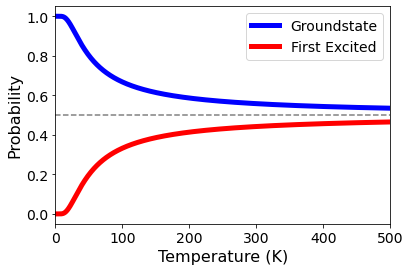

In [3]:
# Evaluate the probablility of being in the ground state
ground_state_energy = eig[0]
first_excited_state_energy = eig[1]

Prob_0 = qwave.boltzmann_probability(ground_state_energy, qPESq, temp, kb) # where 0 here corresponds to the ground state
Prob_1 = qwave.boltzmann_probability(first_excited_state_energy, qPESq, temp, kb) # and 1 corresponds to the first excited state

plt.plot(temp,Prob_0,color='blue',linewidth=5,label='Groundstate')
plt.plot(temp,Prob_1,color='red',linewidth=5,label='First Excited')
plt.hlines(0.5,0,500,color='gray',linestyle='dashed')
plt.xlabel('Temperature (K)', size=16)
plt.ylabel('Probability', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlim(0,500)
plt.legend(fontsize=14)
plt.show()


As you can see, the ground state is populated at low temperatures and the excited states are empty.
As the temperature increases the probability of occupying excited states increases.
As $T \rightarrow \infty$, the probabitly of being in any state approaches $\sum_{i=0}^{2} e_{i}/2 $

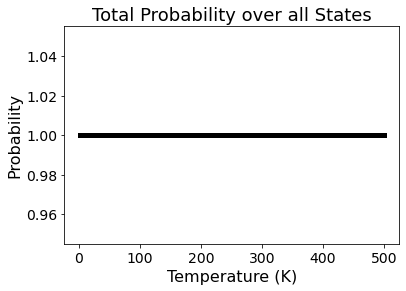

In [4]:
# We can also check to make sure the probability of finding the particle at any state is equal to 1
Tot_Prob = []
for j in range(0,len(temp)):
    Prob = []
    for energy in eig:
        Prob.append(qwave.boltzmann_probability(energy, qPESq, temp, kb)[0])
    Tot_Prob.append(np.sum(Prob))
    
plt.plot(temp,Tot_Prob,color='black',linewidth=5,label='Total Probability')
plt.xlabel('Temperature (K)', size=16)
plt.ylabel('Probability', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Total Probability over all States',size=18)
plt.show()

### Average Energy and Variance

Another useful quantity is the average energy and variance. The average energy (or ensemble average) within the canonical ensemble is defined as:

$$ <E> = \sum_{j} e_{j}p_{j} = \frac{\sum_{j} e_{j} \text{exp}(-e_{j}/k_{b}T)}{\sum_{j} \text{exp}(-e_{j}/k_{b}T)} $$

or by differentiation:

$$ <E> = -\frac{\partial \text{ln}(q(T))}{\partial \beta} $$

(which is how QWavE evaluates the average energy)

where $\beta$ is $1/k_{b}T$. The variance in the energy can also be defined as:

$$ <E^{2}> - <E>^2 = k_{b}T^{2}\frac{\partial E}{\partial T}$$

Which is equivalent to the constant volume heat capacity ($C_{v}$) without the leading constants

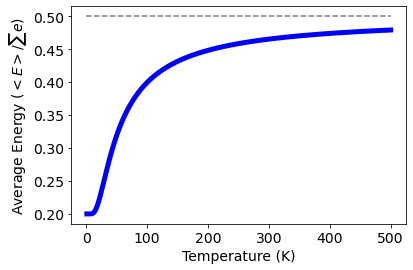

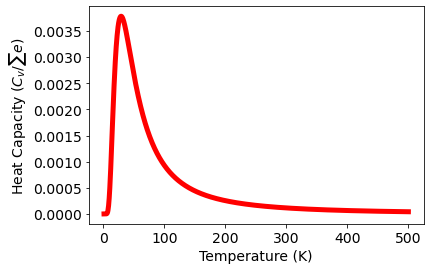

In [5]:
avgE, var, cv = qwave.average_energy(qPESq,temp,kb)

plt.plot(temp,avgE/sum(eig),linewidth=5,color='blue')
plt.hlines(0.5,0,500,color='gray',linestyle='dashed')
plt.ylabel(r'Average Energy ($<E>$/$\sum e$)',size=14)
plt.xlabel(r'Temperature (K)',size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()

plt.plot(temp,cv/sum(eig),linewidth=5,color='red')
plt.ylabel(r'Heat Capacity ($C_{v}$/$\sum e$)',size=14)
plt.xlabel(r'Temperature (K)',size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()

These results are in excellent agreement with analytical solutions for the two-state model (http://www.physics.rutgers.edu/~gersh/351/Lecture%2021.pdf slide 10)

## Predefined Partition Functions

For ease of use, we have also incorporated other commonly used partition functions dervied from the canonical partition function. These include the: harmonic oscillator, hindered translator, rigid rotor, and others. We will show example of using these other functions in another jupyter notebook. In this example, we will harmonic oscillator partition function to find the average energy and heat capacity of an einstein crystal.

The harmonic oscillator partition function is defined as:

$$ q_{HO}(T) = \frac{\exp{(\frac{\nu}{2 k_{b}T})}}{1-\exp{(\frac{\nu}{k_{b}T})}}$$

where $\nu$ is a frequency (cm$^{-1}$)

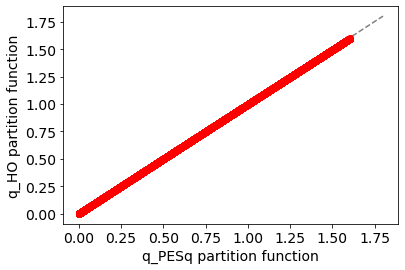

In [6]:
bl = 2       # bohr 
m = 4.65e-26/au_to_kg # approximate mass of a CO molecule
nu = 2143 #cm-1
temp = np.linspace(2.5,5000,10000)

eigen,wave = qwave.schrodinger_solution(bl,m,frequency=nu, problem='HO') #len_eigval forces the number of eigen states to calculate (default = 10)
eig = eigen*hartree_to_ev
qPESq = qwave.q_PESq(eig,temp,kb) # q_PESq takes three options 
                                  # Make sure eig and kb are in the same units
    
qHO = qwave.q_HO(nu,temp,kb,h)    # q_HO takes an additional parameter which is plancks constant in which ever units are appropriate

x = np.linspace(0,1.8)
y = x
plt.plot(x,y,linestyle='dashed',color='gray')
plt.plot(qPESq,qHO,marker='o',markerfacecolor='None',markeredgecolor='red')
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel('q_PESq partition function',size=14)
plt.ylabel('q_HO partition function',size=14)
plt.show()

As you can see, both modules give the same result. NOTE: in order to achieve perfect parity, the box length needs to be adjusted to "match" with the curvature of the potential, change the box length from 2 to 10 to see what happens. As such, it is highly recommended to use the q_HO (or other analytic expressions) when you know the shape of the potential.

Now, lets run through the same exercise to get the average energy and Cv of the einstein crystal

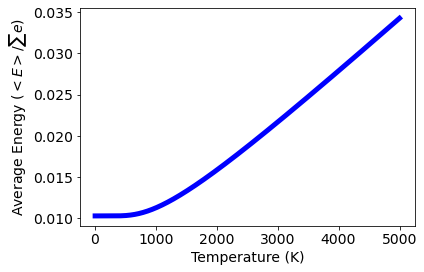

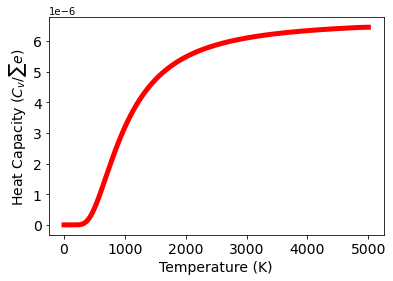

In [8]:
avgE, var, cv = qwave.average_energy(qHO,temp,kb)

plt.plot(temp,avgE/sum(eig),linewidth=5,color='blue')
# plt.hlines(0.5,0,500,color='gray',linestyle='dashed')
plt.ylabel(r'Average Energy ($<E>$/$\sum e$)',size=14)
plt.xlabel(r'Temperature (K)',size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()

plt.plot(temp,cv/sum(eig),linewidth=5,color='red')
plt.ylabel(r'Heat Capacity ($C_{v}$/$\sum e$)',size=14)
plt.xlabel(r'Temperature (K)',size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()

## Grand Canonical Partition function ???

## Microcanonical Partition function ???

Which again, is as expected. 


Hopefully this introductory notebook has familiarized you with the selection of partition functions as well as some basic statistics one can do in QWavE. If there are any bugs, issues or comments, please direct them to the authors at on the GitHub repository at https://github.com/cwaitt/QWavE.